# I16547 has "twin salty disks" per Tanaka et al

https://ui.adsabs.harvard.edu/abs/2020ApJ...900L...2T/abstract

In [1]:
cd /orange/adamginsburg/salt/sanhueza/IRAS16547

/orange/adamginsburg/salt/sanhueza/IRAS16547


In [2]:
ls

23Na-35Clv_0-0_J_18-17.fits
23Na-35Clv_1-1_J_17-16.fits
23Na-35Clv_1-1_J_18-17.fits
23Na-35Clv_2-2_J_17-16.fits
cutout.reg
h2ocube.fits
I16547A_naclPV_withcolorcurves.png
I16547A_Sanhueza_naclPV_withcolorcurves.png
IRAS165474247_G343.12-0.06.config8.cont_avg.selfcal_0.5_hogbom.image.fits
IRAS165474247_G343.12-0.06.config8.spw0.robust0.5.image_co1_smaller.fits
IRAS165474247_G343.12-0.06.config8.spw0.robust0.5.image_small.fits
IRAS165474247_G343.12-0.06.config8.spw1.robust0.5.image_co1_smaller.fits
IRAS165474247_G343.12-0.06.config8.spw1.robust0.5.image_small.fits
IRAS165474247_G343.12-0.06.config8.spw2.robust0.5.image_co1_smaller.fits
IRAS165474247_G343.12-0.06.config8.spw2.robust0.5.image_small.fits
IRAS165474247_G343.12-0.06.config8.spw3.robust0.5.image_co1_smaller.fits
IRAS165474247_G343.12-0.06.config8.spw3.robust0.5.image_small.fits
NaCl_v_le_3_stackcube.fits
spectra/


In [3]:
targetname = 'IRAS165474247_G343.12-0.06'

for fn in glob.glob("*.fits"):
    print('app

In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b2a91779910>

In [5]:
from astropy.table import Table
from astropy import table

In [6]:
import pprint

In [7]:
import scipy, scipy.ndimage

In [8]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [9]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('cutout.reg')
#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [10]:
reg[0].center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (343.12679073, -0.06289123)>

In [11]:
peakA = coordinates.SkyCoord('16:58:17.2082 -42:52:07.421', frame='icrs', unit=(u.hour, u.deg))
peakB = coordinates.SkyCoord('16:58:17.2173 -42:52:07.461', frame='icrs', unit=(u.hour, u.deg))

# NaCl Stackl

In [12]:
from spectral_cube.analysis_utilities import stack_cube

In [13]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [14]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [15]:
flist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_small.fits'))

In [16]:
flist

['IRAS165474247_G343.12-0.06.config8.spw3.robust0.5.image_small.fits',
 'IRAS165474247_G343.12-0.06.config8.spw2.robust0.5.image_small.fits',
 'IRAS165474247_G343.12-0.06.config8.spw0.robust0.5.image_small.fits',
 'IRAS165474247_G343.12-0.06.config8.spw1.robust0.5.image_small.fits']

In [17]:
#from dask.diagnostics import ProgressBar
#pbar = ProgressBar()
#pbar.register()

import dask
dask.config.set(scheduler='threads', num_workers=8)

In [18]:
for fn in flist:
    for rr,regn in ( (reg, 'co1'), ):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile):
            cube = SpectralCube.read(fn, use_dask=False).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            #with cube.use_dask_scheduler('threads', num_workers=8):
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb)
            scube.to(u.K).write(outfile, overwrite=True)

In [19]:
regn = "co1"
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(3840, 64, 79) and unit=K and chunk size (1920, 64, 79):
  n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
  n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062445751.200 Hz:220937033054.715 Hz,
 DaskSpectralCube with shape=(3840, 64, 79) and unit=K and chunk size (1920, 64, 79):
  n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
  n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062431537.000 Hz:232937018840.515 Hz,
 DaskSpectralCube with shape=(3840, 64, 79) and unit=K and chunk size (1920, 64, 79):
  n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
  n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
  n_s:   3840  t

In [20]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()
print(f"Common beam: {cb}")
cb

Common beam: 1.4528249869656476e-13 sr


Beam: BMAJ=0.09501456115463358 arcsec BMIN=0.057412833325110275 arcsec BPA=124.14589905847774 deg

In [21]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [22]:
vcen = -27.5 * u.km/u.s # from Patricio

In [23]:
from astropy import log
log.setLevel('INFO')

In [24]:
for ln, frq in zip(linenames, linelist):
    for cube in cubes:
        scube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=frq).spectral_slab(vcen-30*u.km/u.s, vcen+30*u.km/u.s)
        if len(scube) > 1:
            print(ln, scube)
            scube.to(u.K).write(ln.replace("=","_").replace(" ","_")+".fits", overwrite=True)

23Na-35Clv=2-2 J=17-16 DaskSpectralCube with shape=(91, 64, 79) and unit=K and chunk size (91, 64, 79):
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:      -57.670 km / s:       2.771 km / s


23Na-35Clv=1-1 J=17-16 DaskSpectralCube with shape=(91, 64, 79) and unit=K and chunk size (91, 64, 79):
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:      -57.689 km / s:       2.303 km / s


23Na-35Clv=1-1 J=18-17 DaskSpectralCube with shape=(97, 64, 79) and unit=K and chunk size (97, 64, 79):
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:     97  type_s: VRAD      unit_s: km / s  range:      -57.638 km / s:       2.804 km / s


23Na-35Clv=0-0 J=18-17 DaskSpectralCube with shape=(97, 64, 79) and unit=K and chunk size (97, 64, 79):
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:     97  type_s: VRAD      unit_s: km / s  range:      -57.490 km / s:       2.503 km / s


In [25]:
#log.setLevel('DEBUG')
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.to(u.K).write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [26]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(91, 64, 79) and unit=K:
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:      -57.670 km / s:       2.771 km / s

In [27]:
jtok = stackc.beam.jtok(217*u.GHz)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


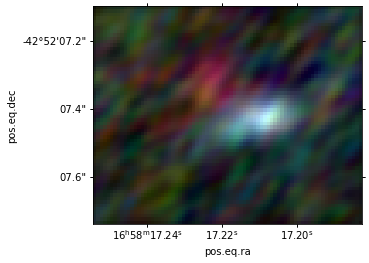

In [28]:
m0b = stackc.spectral_slab(-35*u.km/u.s, -30*u.km/u.s).moment0()
m0g = stackc.spectral_slab(-30*u.km/u.s, -25*u.km/u.s).moment0()
m0r = stackc.spectral_slab(-25*u.km/u.s, -20*u.km/u.s).moment0()
ax = pl.subplot(projection=m0b.wcs.celestial)
rgb = np.array([m0r.value, m0g.value, m0b.value]).swapaxes(0,2).swapaxes(0,1)
rgb /= rgb.max()
ax.imshow(rgb, origin='lower')

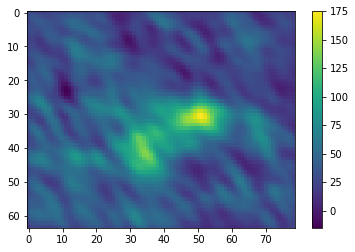

In [30]:
m0r.quicklook(use_aplpy=False)
pl.colorbar()

This next figure should match the bottom-right panel of:

<img src="https://s3.amazonaws.com/aasie/images/2041-8205/900/1/L2/apjlabadfcf4_hr.jpg">

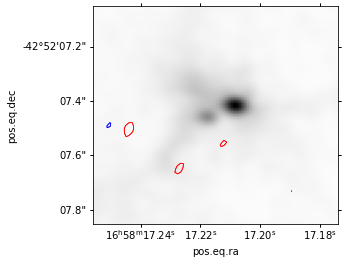

In [31]:
cont = SpectralCube.read('IRAS165474247_G343.12-0.06.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
fig = pl.figure()
fig.add_subplot(projection=cont.wcs.celestial)
ax = fig.gca()
ax.imshow(cont[0].value, cmap='gray_r')
ax.axis((2460,2550,2530,2610))
ax.contour(m0r, colors=['r']*5, levels=[0.02, 0.03], linewidths=[0.75]*5, transform=ax.get_transform(m0r.wcs.celestial))
ax.contour(m0b, colors=['b']*5, levels=[0.02, 0.03], linewidths=[0.75]*5, transform=ax.get_transform(m0b.wcs.celestial))

In [32]:
# where's the water line?
232.6867*(1+vcen/constants.c).decompose()

<Quantity 232.66535562>

In [33]:
pl.rcParams['image.origin'] = 'lower'

DaskSpectralCube with shape=(3840, 64, 79) and unit=K and chunk size (1920, 64, 79):
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062431537.000 Hz:232937018840.515 Hz


DaskSpectralCube with shape=(129, 64, 79) and unit=K and chunk size (129, 64, 79):
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:    129  type_s: VRAD      unit_s: km / s  range:      -67.714 km / s:      12.814 km / s


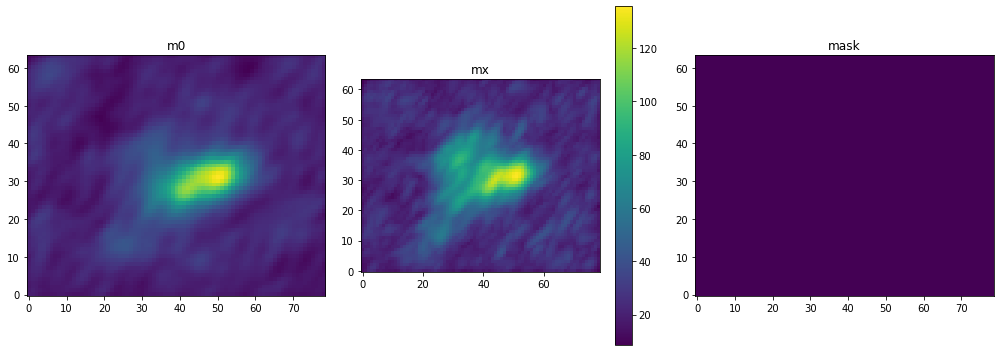

<Figure size 432x288 with 0 Axes>

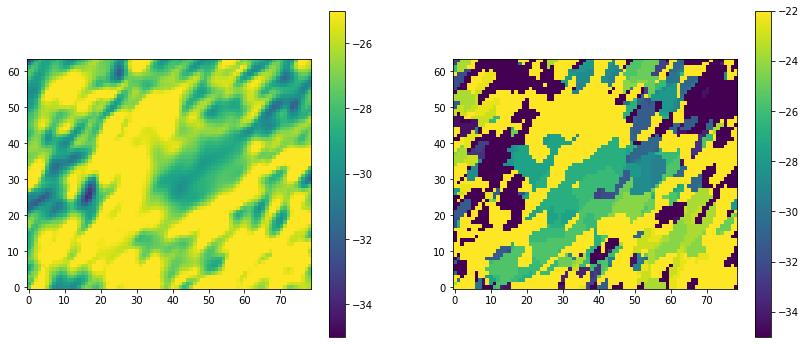

In [36]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
watercube = scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                                                          velocity_convention='radio',
                                                          rest_value=restval)
         .spectral_slab(-40*u.km/u.s+vcen, 40*u.km/u.s+vcen)).to(u.K)
watercube.write('h2ocube.fits',overwrite=True)
scube = watercube.spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen)
print(watercube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.015*mx.unit
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0001*jtok).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-35, vmax=-25)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-35, vmax=-22)
pl.colorbar()


vmap = m1.hdu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


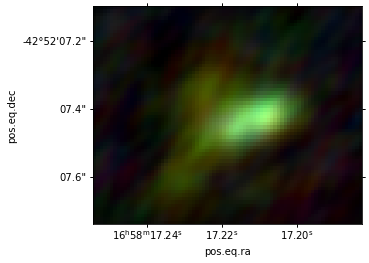

In [37]:
wm0b = watercube.spectral_slab(-45*u.km/u.s, -35*u.km/u.s).moment0()
wm0g = watercube.spectral_slab(-35*u.km/u.s, -25*u.km/u.s).moment0()
wm0r = watercube.spectral_slab(-25*u.km/u.s, -15*u.km/u.s).moment0()
ax = pl.subplot(projection=wm0b.wcs.celestial)
rgb = np.array([wm0r.value, wm0g.value, wm0b.value]).swapaxes(0,2).swapaxes(0,1)
rgb /= rgb.max()
ax.imshow(rgb, origin='lower')

This next figure should match the top-left panel of:

<img src="https://s3.amazonaws.com/aasie/images/2041-8205/900/1/L2/apjlabadfcf4_hr.jpg">

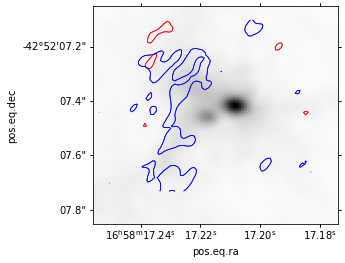

In [38]:
cont = SpectralCube.read('IRAS165474247_G343.12-0.06.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
fig = pl.figure()
fig.add_subplot(projection=cont.wcs.celestial)
ax = fig.gca()
ax.imshow(cont[0].value, cmap='gray_r')
ax.axis((2460,2550,2530,2610))
ax.contour(wm0r, colors=['r']*5, levels=[0.02, 0.03], linewidths=[0.75]*5, transform=ax.get_transform(wm0r.wcs.celestial))
ax.contour(wm0b, colors=['b']*5, levels=[0.02, 0.03], linewidths=[0.75]*5, transform=ax.get_transform(wm0b.wcs.celestial))

DaskSpectralCube with shape=(3840, 64, 79) and unit=K and chunk size (1920, 64, 79):
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 216862448357.200 Hz:218737035660.715 Hz
DaskSpectralCube with shape=(61, 64, 79) and unit=K and chunk size (61, 64, 79):
 n_x:     79  type_x: RA---SIN  unit_x: deg    range:   254.571596 deg:  254.571891 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:   -42.868814 deg:  -42.868639 deg
 n_s:     61  type_s: VRAD      unit_s: km / s  range:      -47.608 km / s:      -7.284 km / s


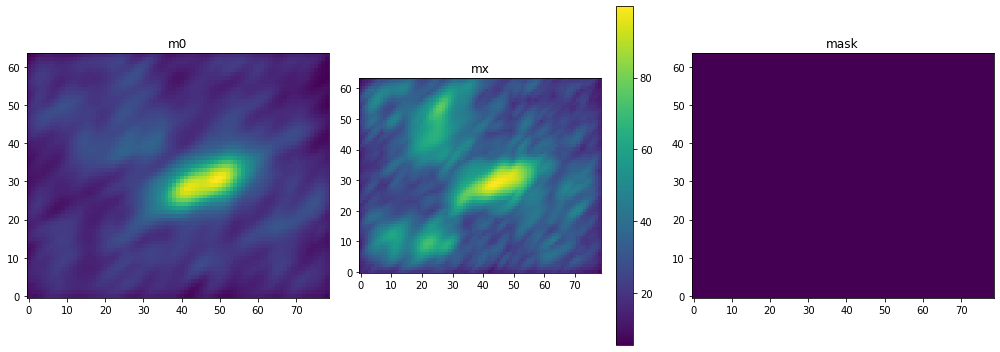

<Figure size 432x288 with 0 Axes>

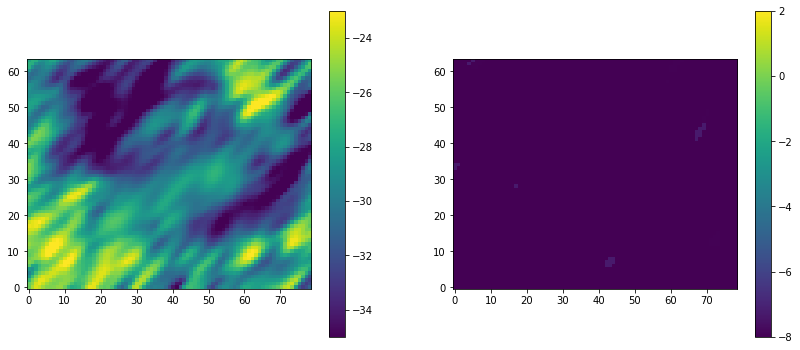

In [39]:
# try creating a vmap based on another line (SiS 12-11)
restval = 217.81764400*u.GHz # '': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.018*mx.unit
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0001*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-35, vmax=-23)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-8, vmax=2)
pl.colorbar()


#vmap = m1.hdu

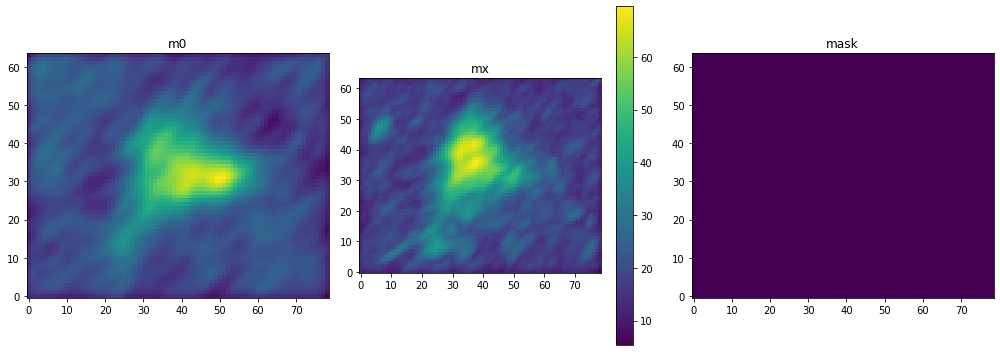

<Figure size 432x288 with 0 Axes>

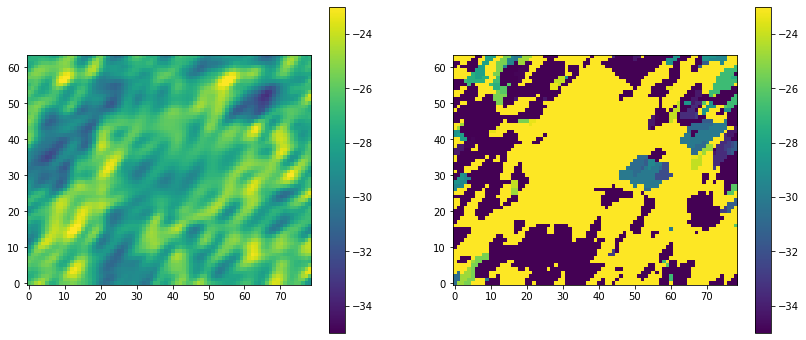

In [40]:
stackc = stackc.subcube_from_regions(reg)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook(use_aplpy=False)
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook(use_aplpy=False)
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.0115*mx.unit
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=15)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0001*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-35, vmax=-23)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-35, vmax=-23)
pl.colorbar()


#vmap = m1.hdu

In [41]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [42]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [43]:
mkdir -p spectra/figures

spw1
spw2
spw3
spw4


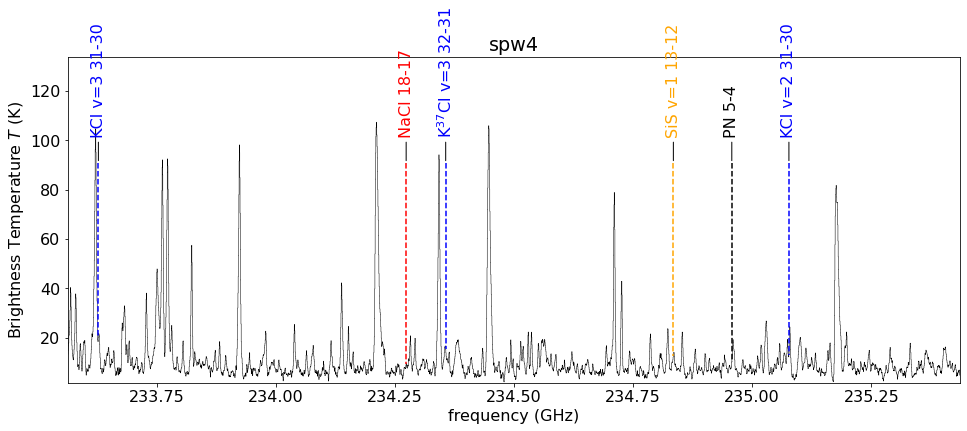

In [44]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

In [45]:
ls spectra/figures

color_labels_IRAS165474247_G343_spw0_stack.png
color_labels_IRAS165474247_G343_spw1_stack.png
color_labels_IRAS165474247_G343_spw2_stack.png
color_labels_IRAS165474247_G343_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
gallery.html
IRAS165474247_G343.12-0.06.config8.spw0.robust0.5.image_co1_smaller_stack.pdf
IRAS165474247_G343.12-0.06.config8.spw0.robust0.5.image_co1_smaller_stack.png
IRAS165474247_G343.12-0.06.config8.spw1.robust0.5.image_co1_smaller_stack.pdf
IRAS165474247_G343.12-0.06.config8.spw1.robust0.5.image_co1_smaller_stack.png
IRAS165474247_G343.12-0.06.config8.spw2.robust0.5.image_co1_smaller_stack.pdf
IRAS165474247_G343.12-0.06.config8.spw2.robust0.5.image_co1_smaller_stack.png
IRAS165474247_G343.12-0.06.config8.spw3.robust0.5.image_co1_smaller_stack.pdf
IRAS165474247_G343.12-0.06.config8.spw3.robust0.5.image_co1_smaller_stack.png
IRAS165474247_G343_spw0_stack.png
IRAS165474247_G343_spw1_stack.png
IRAS165474247_G343_

In [46]:
from IPython.display import Image,display

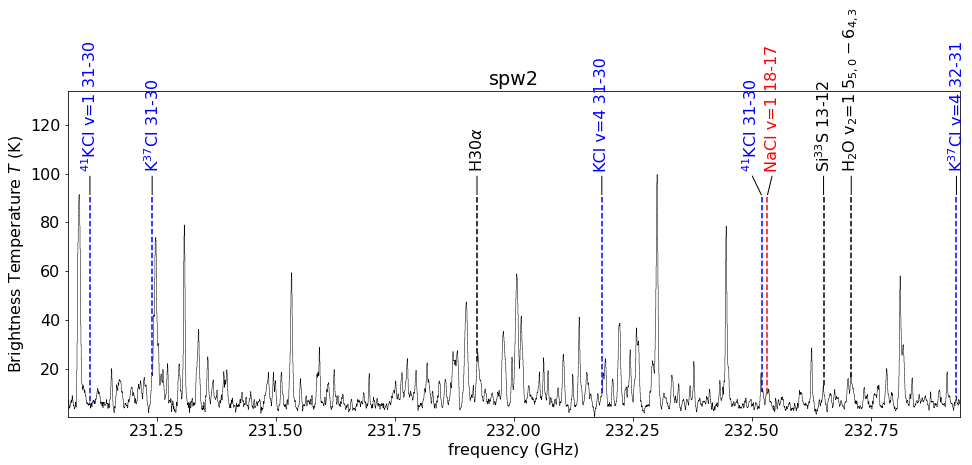

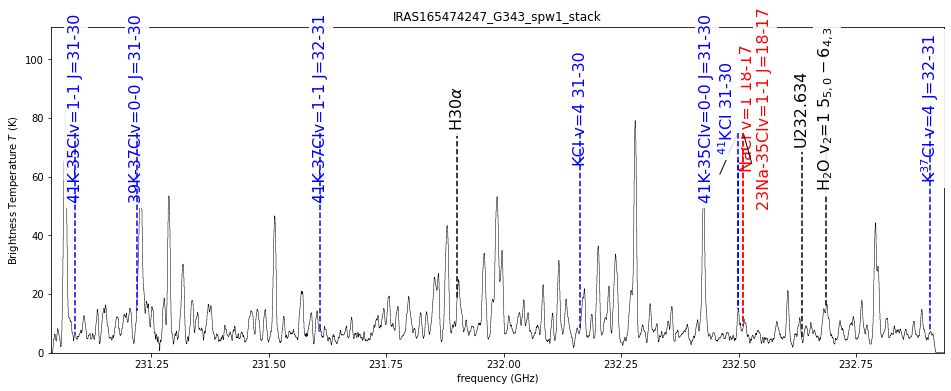

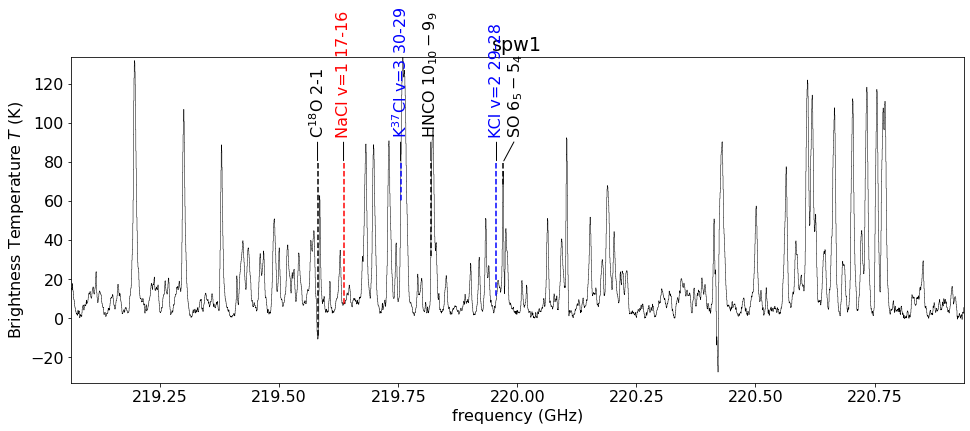

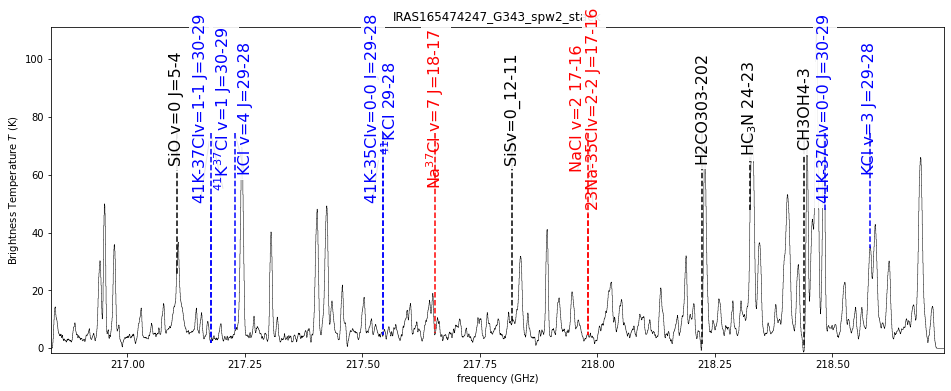

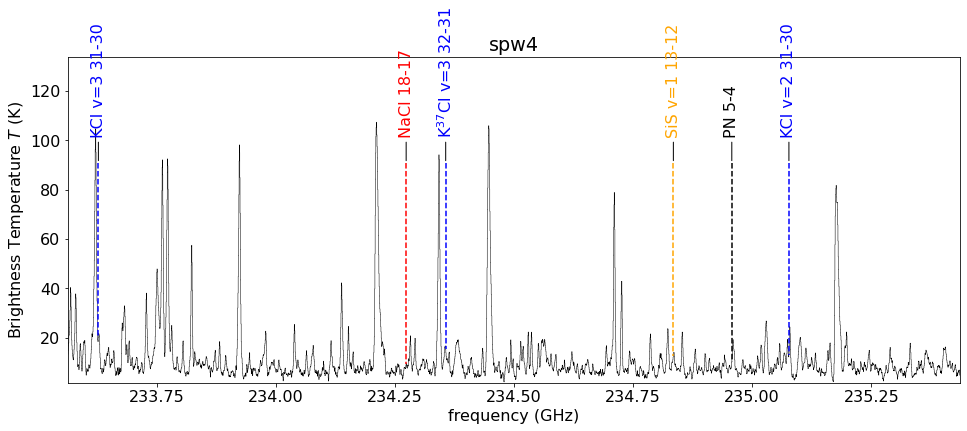

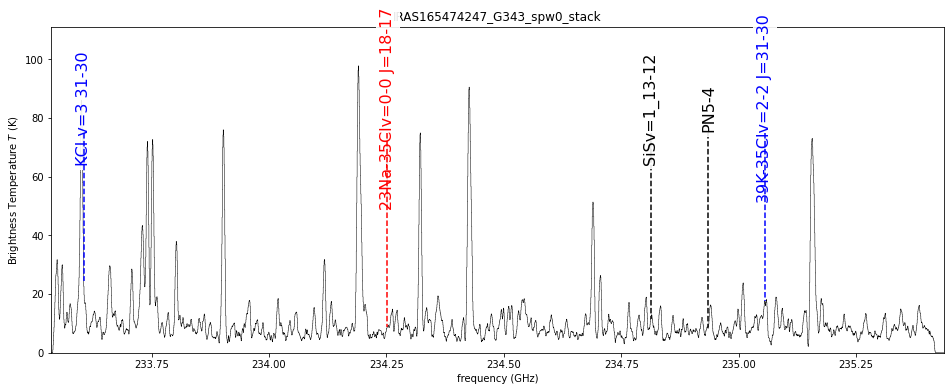

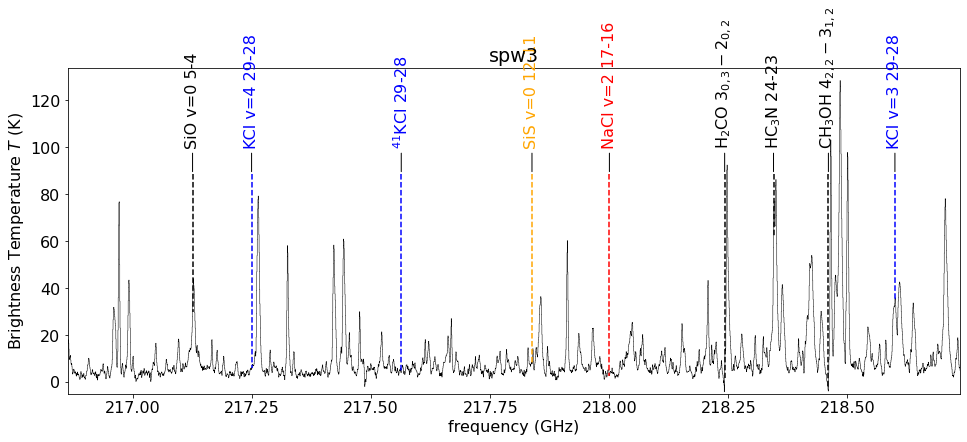

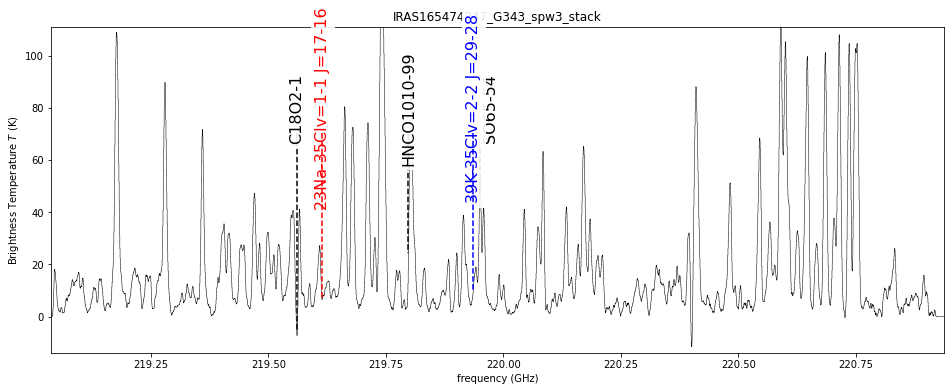

In [47]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

In [ ]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy.io import fits

cbflist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_co1_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    print(basename)
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg)
    # continuum subtract before stacking
    scube = scube - scube.percentile(25, axis=0)
    #mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap.fits')
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

IRAS165474247_G343.12-0.06.config8.spw3.robust0.5.image_co1_smaller


In [ ]:
ls spectra

In [ ]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[4]}_stack'
    stackspectra.append(pysp)

In [ ]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures')

In [ ]:
pwd

In [ ]:
ls spectra/figures/

In [ ]:
from IPython.display import Image, display

In [ ]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))

In [ ]:
import pvextractor

In [ ]:
pathA = pvextractor.Path(coordinates.SkyCoord([peakA.directional_offset_by(55*u.deg,0.15*u.arcsec, ), peakA.directional_offset_by(-125*u.deg,0.15*u.arcsec, )]))

In [ ]:
pathB = pvextractor.Path(coordinates.SkyCoord([peakB.directional_offset_by(-125*u.deg,0.15*u.arcsec, ), peakB.directional_offset_by(55*u.deg,0.15*u.arcsec, )]))

In [ ]:
pvA = pvextractor.extract_pv_slice(stackc, pathA)

In [ ]:
pvB = pvextractor.extract_pv_slice(stackc, pathB)

In [ ]:
vcenA=-28.5*u.km/u.s
vcenB=-27*u.km/u.s

In [ ]:
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
from show_pv import show_pv
import imp
import show_pv
imp.reload(show_pv)
from show_pv import show_keplercurves, show_pv

In [ ]:
fig,ax,cb,con = show_pv(pvA.data, wcs.WCS(pvA.header), origin=0.15*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcenA.value-30, vcenA.value+30]), vcen=vcenA, imvmin=np.nanpercentile(pvA.data, 3), imvmax=np.nanmax(pvA.data),
                        distance=2.9*u.kpc,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 0.15*u.arcsec, 500*u.au, 
                       vcen=vcenA,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=2.9*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I16547 A")
pl.savefig("I16547A_Sanhueza_naclPV_withcolorcurves.png")
#pl.legend(loc='best')

In [ ]:
fig,ax,cb,con = show_pv(pvB.data, wcs.WCS(pvB.header), origin=0.15*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcenB.value-30,vcenB.value+30]), vcen=vcenB, imvmin=np.nanpercentile(pvB.data, 3), imvmax=np.nanmax(pvB.data),
                        distance=2.9*u.kpc,
                        xoffset_label=0.205*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 0.15*u.arcsec, 500*u.au, 
                       vcen=vcenB,
                               masses=[15,30,45],
                               linestyles=['-']*4,
                               colors=['orange','b','c'],
                       radii={},
                       distance=2.9*u.kpc,
                              )
pl.legend(loc='upper left')
pl.title("I16547 B")
pl.savefig("I16547A_Sanhueza_naclPV_withcolorcurves.png")
#pl.legend(loc='best')